In [ ]:
# pip install pandas

## Project Introduction
In this project, I will use three data set that provided by IntelyCare. The three data sets are as follows:
* nurse_info.csv: This gives some basic info about each nurse, designated by their "pid" (provider id). All nurses in our sample have completed at least 5 shifts. There are timestamps for their application date, as well as the day they first accepted a shift, the date they first completed (not accepted) a shift, etc.
* app_behavior.csv: This is the data is new and unstudied. It gives summary info on each app browsing session - specifically how many shifts were viewed and clicked. You might see several browsing sessions in the same hour for the same pid. Other nurses might go days or weeks between sessions. The data only spans from mid Aug 2020 to the present (sometime in 2021), so we'll have to assume that whatever patterns we detect in that window apply elsewhere.
*accept_behavior.csv: This gives timestamps for every time a nurse has accepted a shift, as well as the start time of that shift. If the nurse has "released" or canceled the shift, there's a timestamp for that event as well. The "clientid" designates the facility where the shift is taking place. There are some well-known behaviors in this data set alone. Most nurses are consistent with their preferences for weekdays vs weekends and mornings vs afternoon vs nights, for instance. Some nurses spread their time across several facilities while others consistently return to the same facility for several months. Some nurses release a lot of shifts - they can do so without any penalty from us if they release > 72 hours in advance. Releases < 72 hours incur various nonfinancial penalties and eventually lead to termination if there are too many in a short window.

For this dataset, I plan to apply unsupervised learning algorithms, distance metrics, feature engineering to identify cohorts of nurses with similar in-app behaviors. For the business value, to understand what behavior patterns characterize a given nursing professional, it will allow the company to provide a personalized experience in some important areas.



## Import Library

Imported necessary libraries that will be used

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from datetime import datetime

## Read in the data

The nurse_info.csv file contains the following columns:

* pid: A unique identifier for each nurse.
* still_employed: Indicates whether the nurse is still employed.
* state: The state where the nurse is employed.
* IP Qualification: The nurse's qualification (e.g., RN, LPN).
* IP Apply Timestamp: The timestamp when the nurse applied.
* first_accept_timestamp: The timestamp of the first accepted assignment.
* first_shift_timestamp: The timestamp of the first shift worked.
* fifth_shift_timestamp: The timestamp of the fifth shift worked.
* termination_timestamp: The timestamp of employment termination, if applicable.
* IP Application Source: The source of the application.
* Prior Work History (years): The number of years of prior work history.
* Prior Work History (distinct jobs): The number of distinct jobs in the prior work history.


The accept_behavior.csv file provides information about the shifts accepted by nurses, with the following columns:

* pid: The unique identifier for each nurse, linking to the pid in nurse_info.csv.
* accept_time: The timestamp when a shift was accepted by the nurse.
* shift_time: The scheduled time of the accepted shift.
* release_time: The timestamp when a shift was released or cancelled, if applicable.
* clientid: An identifier for the client or facility for which the shift was accepted.

The app_behavior.csv file contains information about the interaction of nurses with the shift-scheduling application. The columns are as follows:

* pid: A unique identifier for each nurse, linking to the pid in nurse_info.csv.
* sessionDate: The date and time of the app session.
* viewedShifts: The number of shifts viewed by the nurse during the session.
* clickedShifts: The number of shifts clicked on for more details during the session.

In [ ]:
import pandas as pd

nurse_info_df = pd.read_csv('/content/nurse_info.csv')
app_behavior_df = pd.read_csv('/content/app_behavior.csv')
accept_behavior_df = pd.read_csv('/content/accept_behavior.csv')

nurse_info_head = nurse_info_df.head()
app_behavior_head = app_behavior_df.head()
accept_behavior_head = accept_behavior_df.head()

(nurse_info_head, app_behavior_head, accept_behavior_head)


(    pid still_employed state IP Qualification IP Apply Timestamp  \
 0  2994            Yes    MA               RN         2017-03-15   
 1  2997            Yes    MA               RN         2017-03-15   
 2  3049            Yes    MA              LPN         2017-03-16   
 3  3061            Yes    MA              LPN         2017-03-16   
 4  3075            Yes    MA               RN         2017-03-18   
 
   first_accept_timestamp first_shift_timestamp fifth_shift_timestamp  \
 0             2017-05-13            2017-05-13            2017-05-18   
 1             2017-03-16            2017-03-17            2017-04-09   
 2             2017-03-21            2017-03-27            2017-04-17   
 3             2019-03-18            2019-03-24            2019-04-06   
 4             2018-08-17            2018-08-19            2018-10-27   
 
   termination_timestamp IP Application Source  Prior Work History (years)  \
 0                   NaN               Unknown                    

##Data Visulization

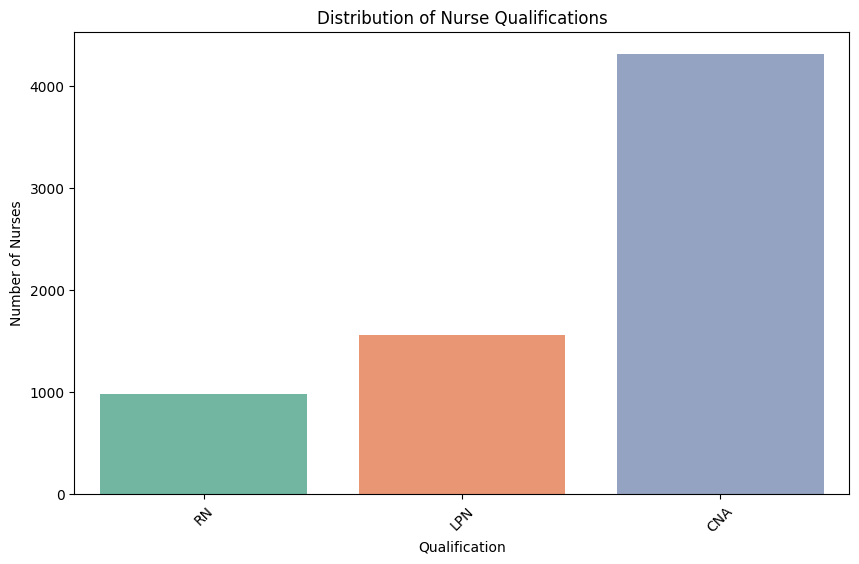

In [ ]:
# Visualization 1: Qualification Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='IP Qualification', data=nurse_info_df, palette='Set2')
plt.title('Distribution of Nurse Qualifications')
plt.xlabel('Qualification')
plt.ylabel('Number of Nurses')
plt.xticks(rotation=45)
plt.show()


Based on this plot, we can see the distribution of the nurse qulifications. In our dataset, we have three types of nurse. And CNA is the major nurse who used the app.

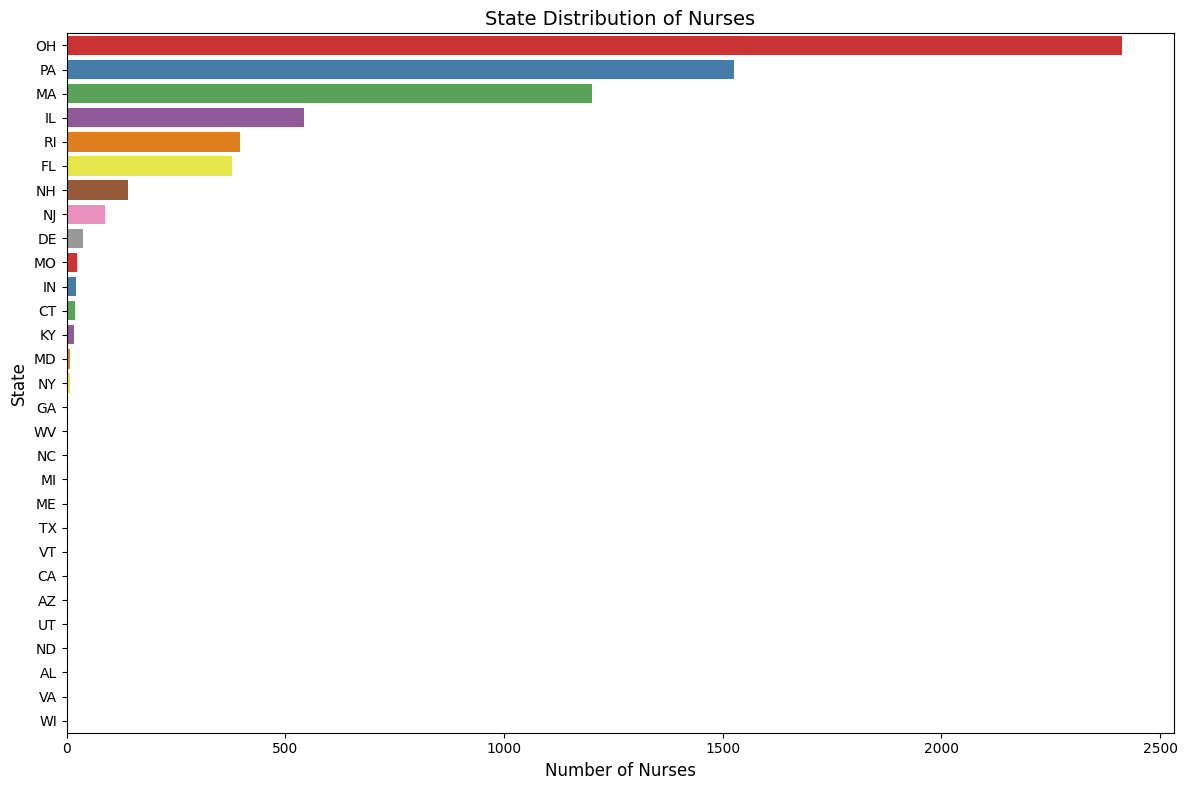

In [ ]:
# Visualization 2: State Distribution

plt.figure(figsize=(12, 8))

# Countplot for nurse state distribution
sns.countplot(y='state', data=nurse_info_df, palette='Set1', order = nurse_info_df['state'].value_counts().index)

# Adding titles and labels
plt.title('State Distribution of Nurses', fontsize=14)
plt.xlabel('Number of Nurses', fontsize=12)
plt.ylabel('State', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

The nurses who use the app are mainly located in OH, PA, MA, IL, RI, FL and NH.

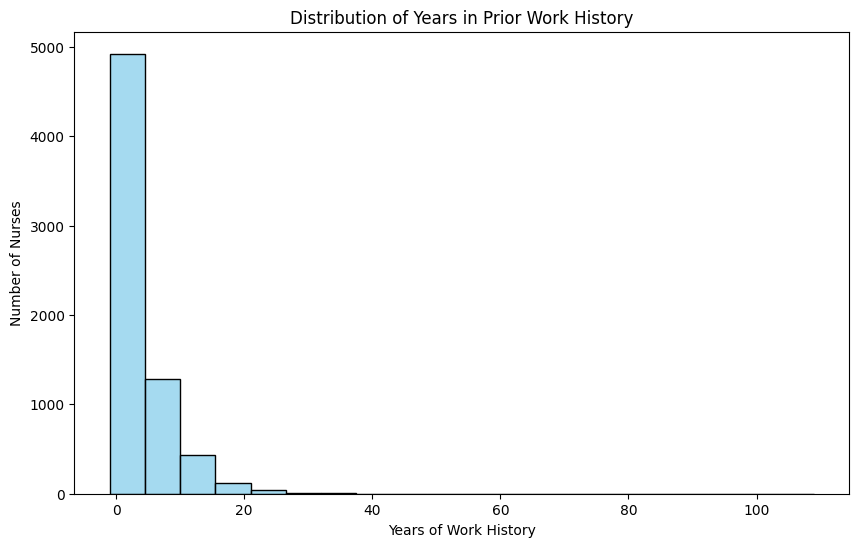

In [ ]:
# Visualization 3: Work History Distribution

# Histogram for the number of years in work history
plt.figure(figsize=(10, 6))
sns.histplot(nurse_info_df['Prior Work History (years)'], bins=20, kde=False, color='skyblue')
plt.title('Distribution of Years in Prior Work History')
plt.xlabel('Years of Work History')
plt.ylabel('Number of Nurses')
plt.show()

The histogram shows the distribution of the number of years nurses have in their work history.

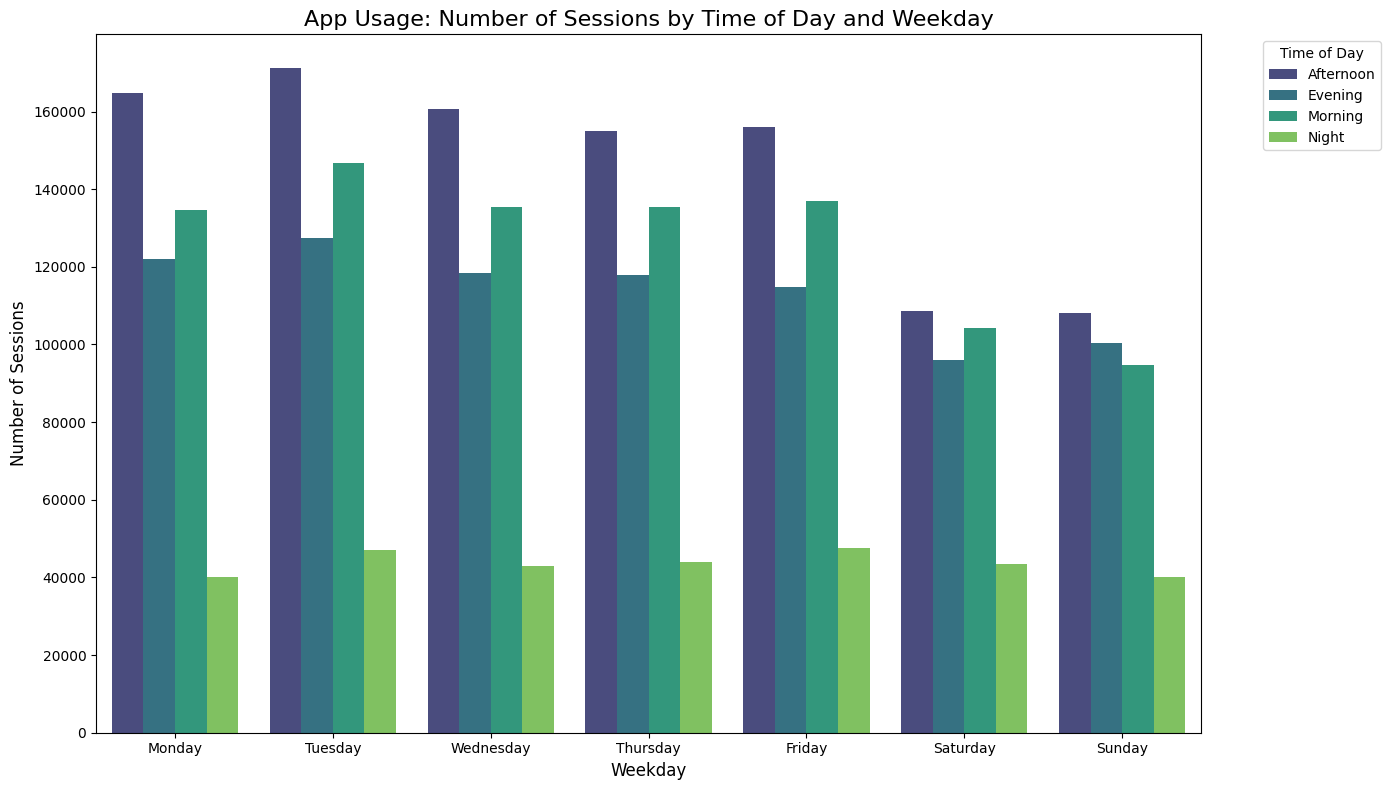

In [ ]:
# Convert the 'sessionDate' to datetime and extract the day of the week and hour
app_behavior_df['sessionDate'] = pd.to_datetime(app_behavior_df['sessionDate'], errors='coerce')
app_behavior_df['weekday'] = app_behavior_df['sessionDate'].dt.day_name()
app_behavior_df['hour'] = app_behavior_df['sessionDate'].dt.hour

# Define time categories (night, morning, afternoon, evening)
def categorize_time(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

app_behavior_df['time_of_day'] = app_behavior_df['hour'].apply(categorize_time)

# Aggregate the data by weekday and time_of_day
aggregated_data = app_behavior_df.groupby(['weekday', 'time_of_day']).agg({
    'viewedShifts': 'sum',
    'clickedShifts': 'sum',
    'pid': 'count'
}).reset_index()

# Rename columns for clarity
aggregated_data.rename(columns={'pid': 'sessionCount'}, inplace=True)

# Adjusting the order of days for the bar plot
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
aggregated_data['weekday'] = pd.Categorical(aggregated_data['weekday'], categories=day_order, ordered=True)

# Recreating the bar plot with the correct order of days
plt.figure(figsize=(14, 8))
sns.barplot(x='weekday', y='sessionCount', hue='time_of_day', data=aggregated_data, palette='viridis')
plt.title('App Usage: Number of Sessions by Time of Day and Weekday', fontsize=16)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.legend(title='Time of Day', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Combined Data set
Due to the size of the data, I only chose 1% of the data randomly from app_behavior and accept_behavior then combine to the nurse_info. The original combination of three data sets contained over 2 million data points which is not sufficient for my python enviroment.

In [ ]:
app_behavior_sample = app_behavior_df.sample(frac=0.01, random_state=42)
accept_behavior_sample = accept_behavior_df.sample(frac=0.01, random_state=42)

combined_df = pd.merge(nurse_info_df, app_behavior_sample, on='pid', how='inner')
combined_df = pd.merge(combined_df, accept_behavior_sample, on='pid', how='inner')
combined_df.head()
# Check for missing values in each column
missing_values = combined_df.isnull().sum()
# Print the summary of missing values
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 pid                                       0
still_employed                            0
state                                     0
IP Qualification                          0
IP Apply Timestamp                        0
first_accept_timestamp                    0
first_shift_timestamp                     0
fifth_shift_timestamp                     0
termination_timestamp                 25972
IP Application Source                     0
Prior Work History (years)               77
Prior Work History (distinct jobs)        0
sessionDate                               0
viewedShifts                              0
clickedShifts                             0
weekday                                   0
hour                                      0
time_of_day                               0
accept_time                               0
shift_time                                0
release_time                          21538
clientid                                  0


In [ ]:
combined_df = combined_df.dropna(axis=1)
missing_values = combined_df.isnull().sum()
# Print the summary of missing values
print("Missing Values in Each Column:\n", missing_values)
combined_df.head()

Missing Values in Each Column:
 pid                                   0
still_employed                        0
state                                 0
IP Qualification                      0
IP Apply Timestamp                    0
first_accept_timestamp                0
first_shift_timestamp                 0
fifth_shift_timestamp                 0
IP Application Source                 0
Prior Work History (distinct jobs)    0
sessionDate                           0
viewedShifts                          0
clickedShifts                         0
weekday                               0
hour                                  0
time_of_day                           0
accept_time                           0
shift_time                            0
clientid                              0
dtype: int64


,pid,still_employed,state,IP Qualification,IP Apply Timestamp,first_accept_timestamp,first_shift_timestamp,fifth_shift_timestamp,IP Application Source,Prior Work History (distinct jobs),sessionDate,viewedShifts,clickedShifts,weekday,hour,time_of_day,accept_time,shift_time,clientid
0,3061,Yes,MA,LPN,2017-03-16,2019-03-18,2019-03-24,2019-04-06,Unknown,1,2020-09-15 15:00:00,15,1,Tuesday,15,Afternoon,2019-08-04 14:04:02,2019-08-04 23:00:00,324
1,3061,Yes,MA,LPN,2017-03-16,2019-03-18,2019-03-24,2019-04-06,Unknown,1,2020-09-15 15:00:00,15,1,Tuesday,15,Afternoon,2019-09-13 07:05:26,2019-09-13 09:00:00,244
2,3061,Yes,MA,LPN,2017-03-16,2019-03-18,2019-03-24,2019-04-06,Unknown,1,2020-09-06 12:30:00,20,0,Sunday,12,Afternoon,2019-08-04 14:04:02,2019-08-04 23:00:00,324
3,3061,Yes,MA,LPN,2017-03-16,2019-03-18,2019-03-24,2019-04-06,Unknown,1,2020-09-06 12:30:00,20,0,Sunday,12,Afternoon,2019-09-13 07:05:26,2019-09-13 09:00:00,244
4,3061,Yes,MA,LPN,2017-03-16,2019-03-18,2019-03-24,2019-04-06,Unknown,1,2020-09-08 14:30:00,22,1,Tuesday,14,Afternoon,2019-08-04 14:04:02,2019-08-04 23:00:00,324


<Figure size 1200x600 with 0 Axes>

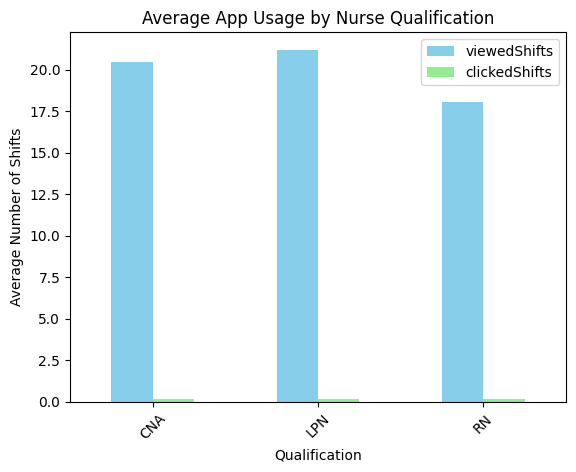

In [ ]:
# Analysis 1: Correlation between Nurse Qualifications and App Usage
# Aggregating data based on qualifications
qualification_app_usage = combined_df.groupby('IP Qualification').agg({
    'viewedShifts': 'mean',
    'clickedShifts': 'mean'
}).reset_index()

# Plotting the data
plt.figure(figsize=(12, 6))
qualification_app_usage.plot(x='IP Qualification', y=['viewedShifts', 'clickedShifts'], kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Average App Usage by Nurse Qualification')
plt.xlabel('Qualification')
plt.ylabel('Average Number of Shifts')
plt.xticks(rotation=45)
plt.show()

# Preparing data for Analysis 2: App Usage by Employment Status
employment_app_usage = combined_df.groupby('still_employed').agg({
    'viewedShifts': 'mean',
    'clickedShifts': 'mean'
}).reset_index()

<Figure size 1400x800 with 0 Axes>

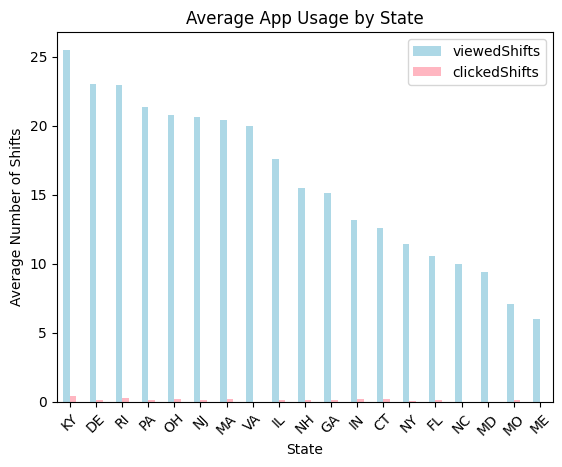

In [ ]:
# Analysis 2: State-wise App Usage
# Aggregating data based on state
state_app_usage = combined_df.groupby('state').agg({
    'viewedShifts': 'mean',
    'clickedShifts': 'mean'
}).reset_index().sort_values(by='viewedShifts', ascending=False)

# Plotting the data
plt.figure(figsize=(14, 8))
state_app_usage.plot(x='state', y=['viewedShifts', 'clickedShifts'], kind='bar', color=['#add8e6', '#ffb6c1'])
plt.title('Average App Usage by State')
plt.xlabel('State')
plt.ylabel('Average Number of Shifts')
plt.xticks(rotation=45)
plt.show()

## Scale the Data and proceed PCA and K-mean clustering

In [ ]:
numerical_columns = ['Prior Work History (distinct jobs)', 'viewedShifts', 'clickedShifts', 'hour']
numerical_data = combined_df[numerical_columns]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

In [ ]:
scaled_data

array([[-0.51446301, -0.18938248,  1.67992614,  0.33723643],
       [-0.51446301, -0.18938248,  1.67992614,  0.33723643],
       [-0.51446301, -0.01216835, -0.35922198, -0.15918998],
       ...,
       [-0.51446301, -0.26026814, -0.35922198,  0.33723643],
       [-0.51446301, -0.33115379, -0.35922198,  0.00628549],
       [-0.51446301, -0.33115379, -0.35922198,  0.00628549]])

In [ ]:
# Step 2: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

In [ ]:
pca_result

array([[ 1.0690306 ,  0.04897173],
       [ 1.0690306 ,  0.04897173],
       [-0.20299437, -0.50619424],
       ...,
       [-0.41102916, -0.1649611 ],
       [-0.4386295 , -0.40541177],
       [-0.4386295 , -0.40541177]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

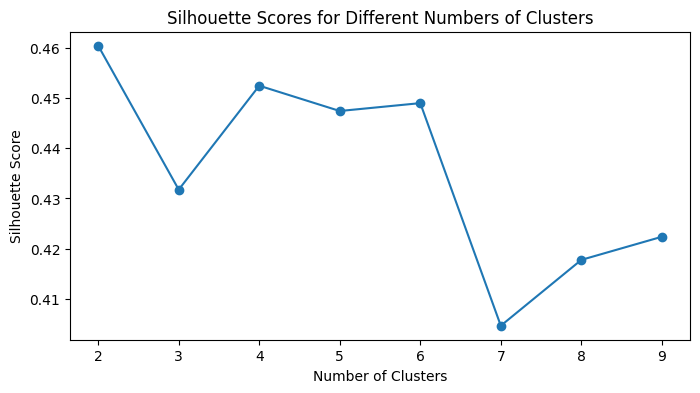

In [ ]:
# Step 3: Determine Optimal Number of Clusters (Silhouette Score)
silhouette_scores = []
for k in range(2, 10):  # Testing for 2 to 10 clusters (silhouette score requires at least 2 clusters)
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_result)
    score = silhouette_score(pca_result, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


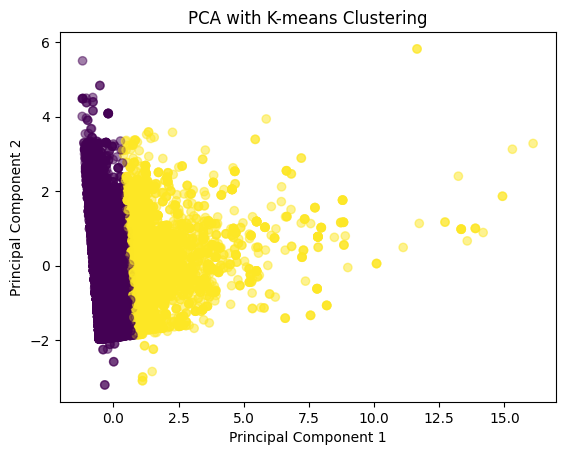

In [ ]:
# Step 4: Perform K-means Clustering with the Optimal Number of Clusters
# Assume the optimal number of clusters is found to be 'optimal_k'
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Step 5: Visualization
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('PCA with K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Cluster Profileing and Visualization

In [ ]:
# Assuming 'clusters' is the output from K-means and 'combined_df' is your original dataset
combined_df['Cluster'] = clusters
combined_df

,pid,still_employed,state,IP Qualification,IP Apply Timestamp,first_accept_timestamp,first_shift_timestamp,fifth_shift_timestamp,IP Application Source,Prior Work History (distinct jobs),sessionDate,viewedShifts,clickedShifts,weekday,hour,time_of_day,accept_time,shift_time,clientid,Cluster
0,3061,Yes,MA,LPN,2017-03-16,2019-03-18,2019-03-24,2019-04-06,Unknown,1,2020-09-15 15:00:00,15,1,Tuesday,15,Afternoon,2019-08-04 14:04:02,2019-08-04 23:00:00,324,1
1,3061,Yes,MA,LPN,2017-03-16,2019-03-18,2019-03-24,2019-04-06,Unknown,1,2020-09-15 15:00:00,15,1,Tuesday,15,Afternoon,2019-09-13 07:05:26,2019-09-13 09:00:00,244,1
2,3061,Yes,MA,LPN,2017-03-16,2019-03-18,2019-03-24,2019-04-06,Unknown,1,2020-09-06 12:30:00,20,0,Sunday,12,Afternoon,2019-08-04 14:04:02,2019-08-04 23:00:00,324,0
3,3061,Yes,MA,LPN,2017-03-16,2019-03-18,2019-03-24,2019-04-06,Unknown,1,2020-09-06 12:30:00,20,0,Sunday,12,Afternoon,2019-09-13 07:05:26,2019-09-13 09:00:00,244,0
4,3061,Yes,MA,LPN,2017-03-16,2019-03-18,2019-03-24,2019-04-06,Unknown,1,2020-09-08 14:30:00,22,1,Tuesday,14,Afternoon,2019-08-04 14:04:02,2019-08-04 23:00:00,324,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27322,215644,Yes,PA,CNA,2020-11-13,2020-11-19,2020-11-23,2020-11-28,Other,1,2020-12-01 18:45:00,23,1,Tuesday,18,Evening,2020-11-26 12:01:36,2020-12-11 15:00:00,997,1
27323,215644,Yes,PA,CNA,2020-11-13,2020-11-19,2020-11-23,2020-11-28,Other,1,2020-11-27 15:00:00,13,0,Friday,15,Afternoon,2020-11-24 14:32:26,2020-11-27 15:00:00,414,0
27324,215644,Yes,PA,CNA,2020-11-13,2020-11-19,2020-11-23,2020-11-28,Other,1,2020-11-27 15:00:00,13,0,Friday,15,Afternoon,2020-11-26 12:01:36,2020-12-11 15:00:00,997,0
27325,215644,Yes,PA,CNA,2020-11-13,2020-11-19,2020-11-23,2020-11-28,Other,1,2020-11-29 13:15:00,11,0,Sunday,13,Afternoon,2020-11-24 14:32:26,2020-11-27 15:00:00,414,0


In [ ]:
cluster_summary = combined_df.groupby('Cluster').describe()
print(cluster_summary)

             pid                                                        \
           count          mean           std     min      25%      50%   
Cluster                                                                  
0        21976.0  82300.364216  44569.568152  3061.0  47353.0  80695.0   
1         5351.0  77950.203513  43877.545407  3061.0  44448.0  74351.0   

                            Prior Work History (distinct jobs)            ...  \
              75%       max                              count      mean  ...   
Cluster                                                                   ...   
0        116009.0  215644.0                            21976.0  1.293183  ...   
1        111261.0  215644.0                             5351.0  1.257896  ...   

         hour       clientid                                              \
          75%   max    count        mean         std   min    25%    50%   
Cluster                                                                

In [ ]:
# Select specific columns for statistical summary
specific_columns = ['viewedShifts', 'clickedShifts']  # Add any other numeric columns of interest
cluster_specific_stats = combined_df.groupby('Cluster')[specific_columns].describe()

print(cluster_specific_stats)


        viewedShifts                                                      \
               count       mean        std  min   25%   50%   75%    max   
Cluster                                                                    
0            21976.0  14.197625  11.138966  1.0   6.0  11.0  18.0   58.0   
1             5351.0  45.583069  52.575487  1.0  11.0  26.0  65.0  631.0   

        clickedShifts                                                
                count      mean       std  min  25%  50%  75%   max  
Cluster                                                              
0             21976.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0  
1              5351.0  0.899645  0.759871  0.0  1.0  1.0  1.0  11.0  


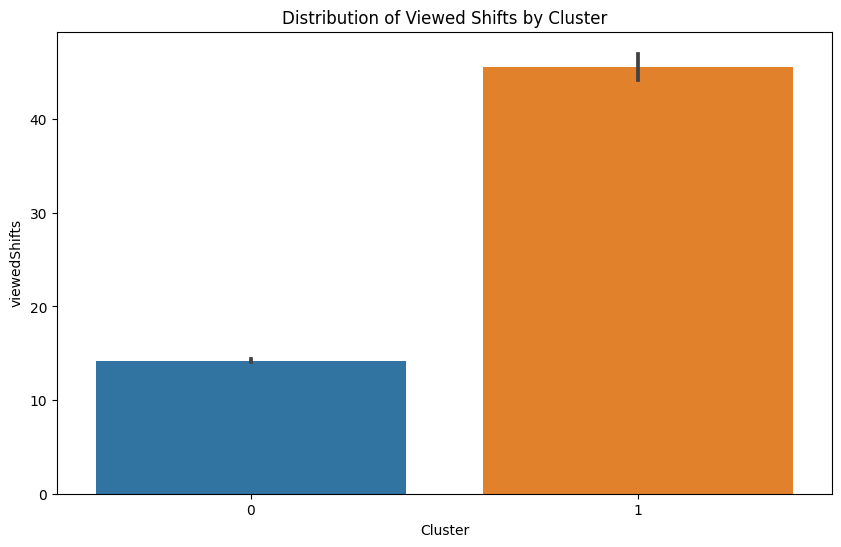

In [ ]:
# Example: Box plot for 'viewedShifts' feature
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='viewedShifts', data=combined_df)
plt.title('Distribution of Viewed Shifts by Cluster')
plt.show()

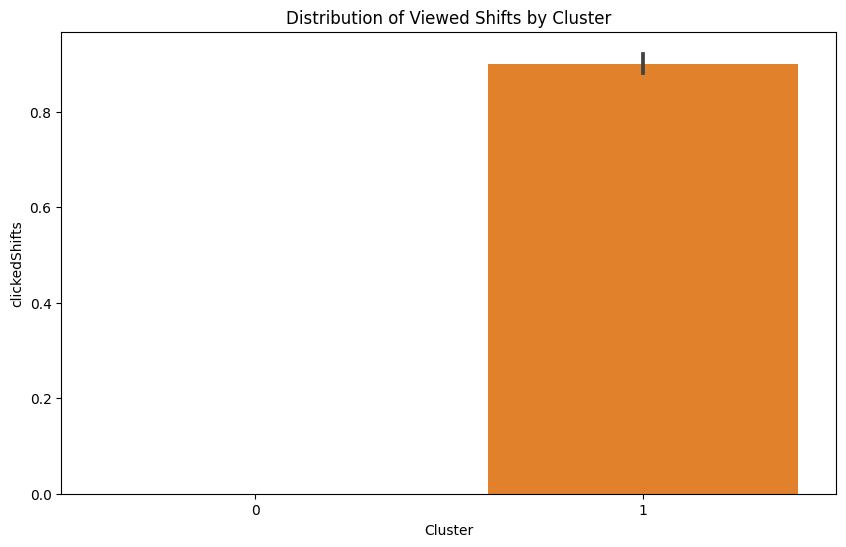

In [ ]:
# Example: Box plot for 'viewedShifts' feature
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='clickedShifts', data=combined_df)
plt.title('Distribution of Clicked Shifts by Cluster')
plt.show()

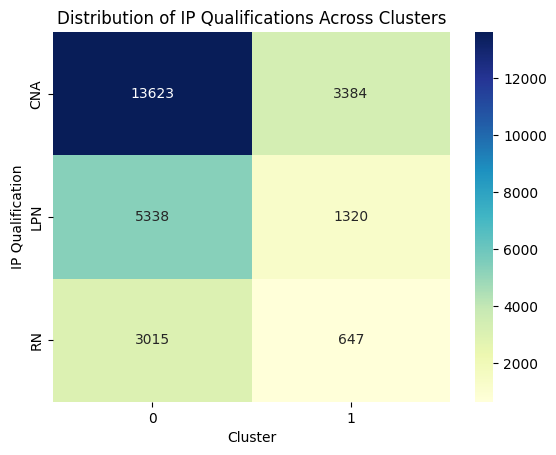

In [ ]:
qualification_cluster_crosstab = pd.crosstab(combined_df['IP Qualification'], combined_df['Cluster'])

sns.heatmap(qualification_cluster_crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Distribution of IP Qualifications Across Clusters')
plt.ylabel('IP Qualification')
plt.xlabel('Cluster')
plt.show()

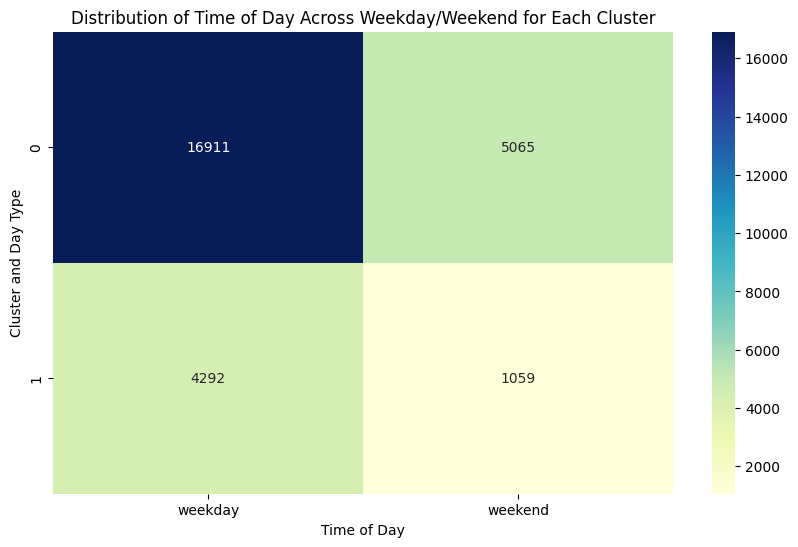

In [ ]:
# Assuming 'weekday' is a column in your DataFrame with day names like 'Monday', 'Tuesday', etc.
combined_df['day_type'] = combined_df['weekday'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'weekday')
# Assuming 'time_of_day' has categories like 'Morning', 'Afternoon', etc.
day_cluster_crosstab = pd.crosstab(index=combined_df['Cluster'], columns=combined_df['day_type'])

plt.figure(figsize=(10, 6))
sns.heatmap(day_cluster_crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Distribution of Time of Day Across Weekday/Weekend for Each Cluster')
plt.ylabel('Cluster and Day Type')
plt.xlabel('Time of Day')
plt.show()


In [ ]:
# For example, summarizing 'day_type'
day_type_summary = combined_df.groupby('Cluster')['day_type'].value_counts().unstack()


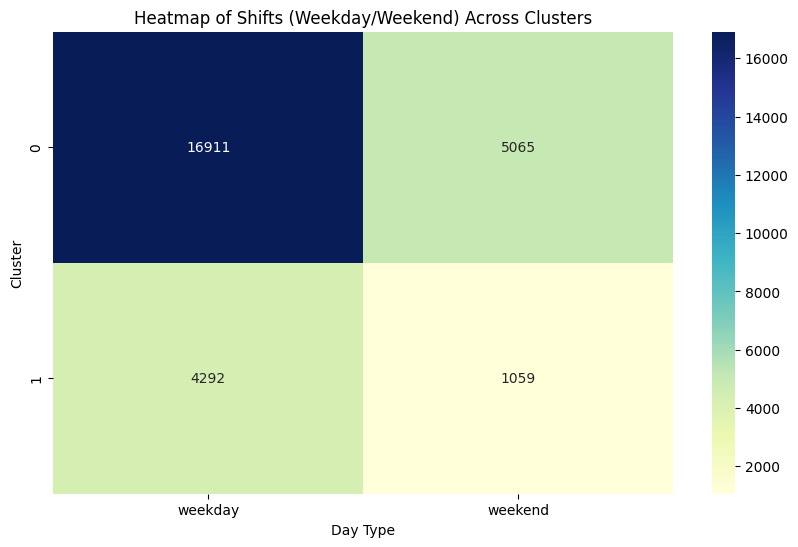

In [ ]:
# Convert 'shift_time' to datetime
combined_df['shift_time'] = pd.to_datetime(combined_df['shift_time'])

# Function to categorize as 'Weekday' or 'Weekend'
def categorize_day_type(day):
    if day.weekday() >= 5:  # 5 and 6 correspond to Saturday and Sunday
        return 'Weekend'
    else:
        return 'Weekday'

# Apply the function to create a new 'day_type' column
combined_df['shift_day_type'] = combined_df['shift_time'].apply(categorize_day_type)
cluster_daytype_crosstab = pd.crosstab(combined_df['Cluster'], combined_df['day_type'])
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_daytype_crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of Shifts (Weekday/Weekend) Across Clusters')
plt.xlabel('Day Type')
plt.ylabel('Cluster')
plt.show()

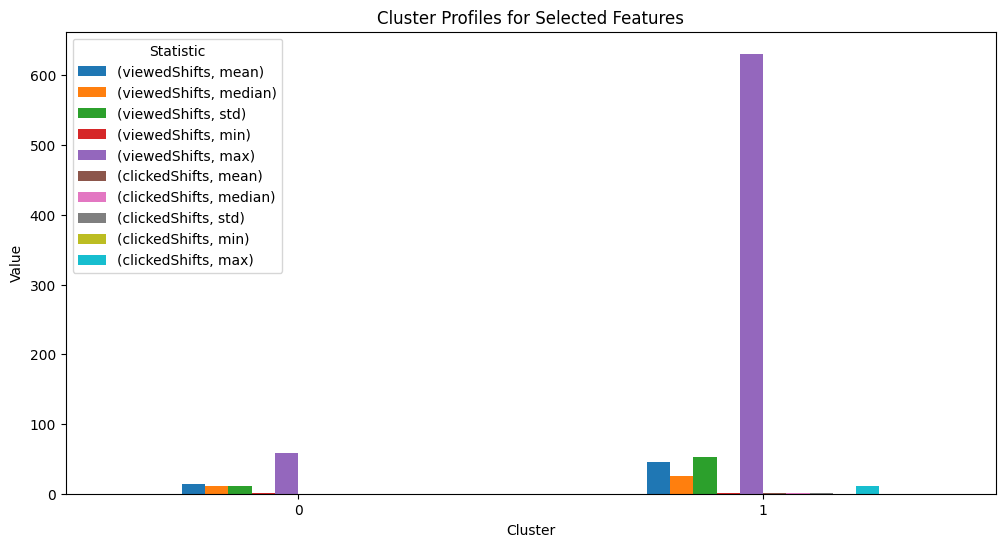

In [ ]:
# Step 1: Select Relevant Features
selected_features = ['viewedShifts', 'clickedShifts']

# Step 2: Calculate Cluster-Centric Statistics
cluster_profiles = combined_df.groupby('Cluster')[selected_features].agg(['mean', 'median', 'std', 'min', 'max'])

# Step 3: Visualize Cluster Profiles (Example: Bar Chart)
cluster_profiles.plot(kind='bar', figsize=(12, 6))
plt.title('Cluster Profiles for Selected Features')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.legend(title='Statistic', loc='upper left')
plt.xticks(rotation=0)
plt.show()

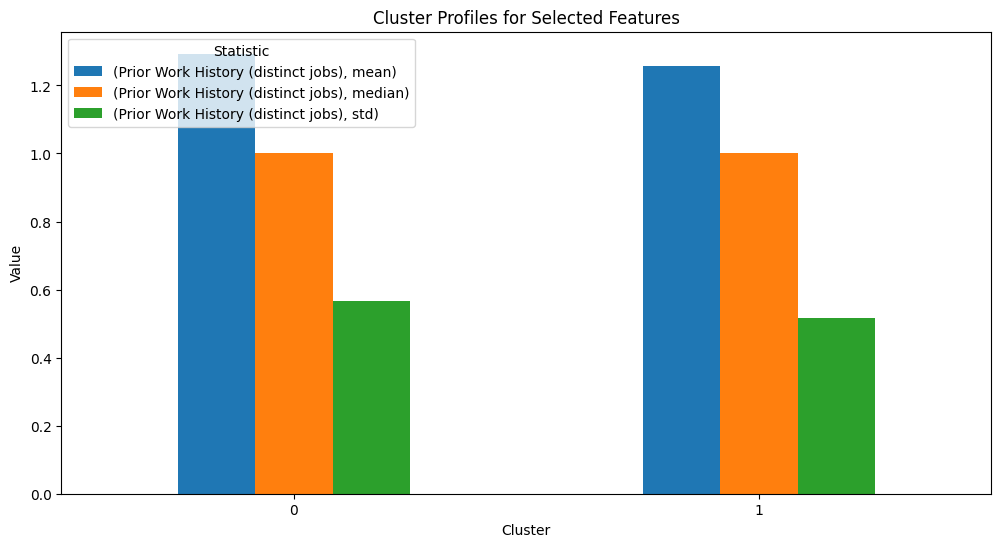

In [ ]:
# Step 1: Select Relevant Features
selected_features = ['Prior Work History (distinct jobs)']

# Step 2: Calculate Cluster-Centric Statistics
cluster_profiles = combined_df.groupby('Cluster')[selected_features].agg(['mean', 'median', 'std'])

# Step 3: Visualize Cluster Profiles (Example: Bar Chart)
cluster_profiles.plot(kind='bar', figsize=(12, 6))
plt.title('Cluster Profiles for Selected Features')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.legend(title='Statistic', loc='upper left')
plt.xticks(rotation=0)
plt.show()

<ipython-input-196-b9fff3f479db>:3: FutureWarning: ['shift_time'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  cluster_profiles = combined_df.groupby('Cluster')[selected_features].agg(['mean', 'median', 'std', 'min', 'max', 'sum'])


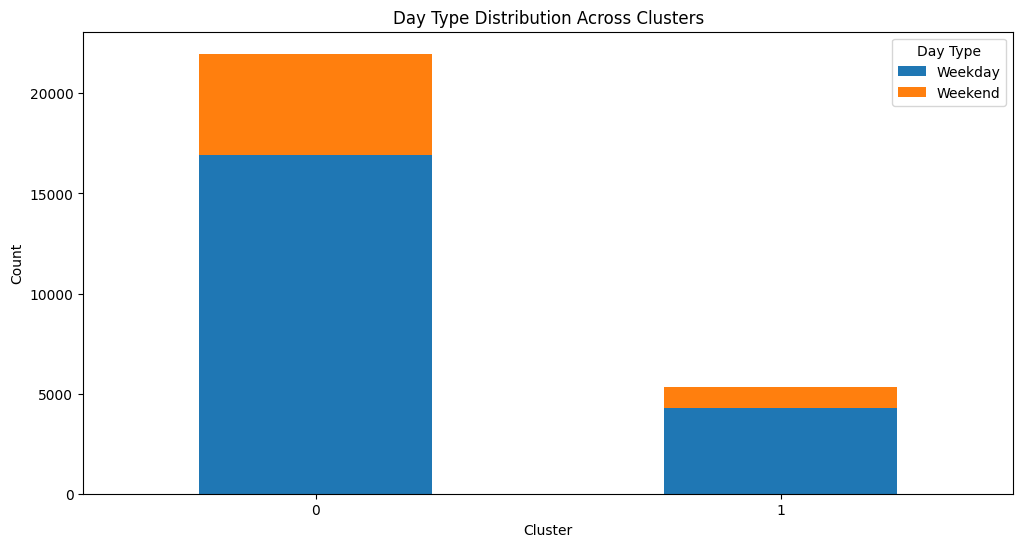

In [ ]:
combined_df['is_weekend'] = (combined_df['weekday'] == 'Saturday') | (combined_df['weekday'] == 'Sunday')
selected_features = ['shift_time', 'is_weekend']
cluster_profiles = combined_df.groupby('Cluster')[selected_features].agg(['mean', 'median', 'std', 'min', 'max', 'sum'])
cluster_daytype_distribution = combined_df.groupby(['Cluster', 'is_weekend']).size().unstack(fill_value=0)
cluster_daytype_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Day Type Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(['Weekday', 'Weekend'], title='Day Type')
plt.show()


## Results and Conclusion

#### PCA with K-means Clustering
The scatter plot titled "PCA with K-means Clustering" visualizes the dataset in a two-dimensional space derived from PCA, with the clusters assigned by the K-means algorithm. In this plot, two distinct clusters are evident, differentiated along the first principal component axis. This axis likely captures the most significant variance within the dataset, with one cluster grouped tightly around lower values and the other spread across higher values of Principal Component 1. The tight grouping of one cluster suggests that those data points share a high degree of similarity in their features, while the more spread-out cluster indicates greater diversity within that group. The clear separation between clusters indicates that PCA has effectively reduced the dimensions while preserving the distinctions necessary for clustering.

#### Cluster Activity Analysis
Moving on to the activity within clusters:

* Viewed and Clicked Shifts: The bar charts for 'Viewed Shifts' and 'Clicked Shifts' by cluster show that Cluster 1 is more actively engaging with the platform than Cluster 0. Individuals in Cluster 1 view and click on more shifts, suggesting higher engagement or possibly a more intensive search for suitable work opportunities.

* Professional Qualifications: The heatmap for IP qualifications indicates a variation in professional backgrounds between the clusters. Cluster 0 has a significantly higher number of CNAs and LPNs, whereas RNs are more evenly distributed. This could reflect differences in job roles, with Cluster 0 possibly representing a workforce with a specific range of qualifications that differ from Cluster 1.

* Time of Day and Week Preference: The heatmaps and bar charts displaying activity across weekdays and weekends suggest that Cluster 0 members are more active during the weekdays, indicating a more conventional work pattern. In contrast, Cluster 1's increased weekend activity might imply flexible schedules or part-time work preferences.

* Work History Diversity: The bar chart for 'Prior Work History (distinct jobs)' shows that Cluster 0 members have a slightly higher diversity in their work history. This could point to individuals who have explored various job roles or had a broader set of experiences.

* Overall Activity by Day Type: The stacked bar chart showing day type distribution highlights that Cluster 0 has a higher overall count of a certain unspecified activity, predominantly on weekdays. This reinforces the idea that Cluster 0 is aligned with traditional employment patterns, while Cluster 1, with less overall activity, may include individuals with varying schedules or less consistent work patterns.

In summary, PCA with K-means clustering has revealed two distinct groups within the dataset: Cluster 0, which seems to be characterized by a traditional work pattern, diverse job experiences, and standard qualifications, and Cluster 1, which is characterized by higher engagement on the platform, a possible preference for non-traditional work schedules, and a somewhat different professional qualification profile. These insights could be valuable for tailoring platform features, job postings, and support services to meet the unique needs and behaviors of each cluster.